# Test on Real Data

## Import

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import argparse

## Definition of Base Learners

In [17]:
def epsilon_greedy_policy(df, arms, epsilon=0.15, c = 0, t = 0, slate_size=5, batch_size=50, fixed = True):
    """
    Epsilon-Greedy Policy for Recommender Systems or Bandit Problems.

    This function implements an epsilon-greedy policy to decide which items 
    to recommend to users based on historical data of user interactions.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset containing user interactions with items. It should include:
        - 'movieId': Identifier for the items (e.g., movies).
        - 'liked': Indicator of whether the user liked the item (1 for like, 0 for dislike).
    arms : list
        The set of all possible items that can be recommended (e.g., a list of movie IDs).
    epsilon : float, optional, default=0.15
        The probability of exploring (choosing random items) rather than exploiting
        (choosing the best-performing items so far).
    slate_size : int, optional, default=5
        The number of recommendations to generate in each step.
    batch_size : int, optional, default=50
        The number of users to serve recommendations before potentially updating the policy.
        (Not directly used in this function but relevant in larger batch-processing contexts).

    Returns
    -------
    recs : numpy.ndarray
        An array of item IDs representing the recommendations for the current step.

    Policy Logic
    ------------
    - With a probability of `epsilon`, the policy chooses to explore:
      - A random set of `slate_size` items is selected from `arms` without replacement.
    - Otherwise (with a probability of `1 - epsilon`), the policy chooses to exploit:
      - Items are ranked by their average like rate (`liked` column in `df`).
      - The top `slate_size` items with the highest mean like rates are recommended.
    - If `df` is empty, the policy defaults to exploration.
    """

    if fixed == False:
        if t==0 :
            epsilon =1
        else:
            epsilon = c/t
     
    # Draw a 0 or 1 from a binomial distribution, with epsilon likelihood of drawing a 1
    explore = np.random.binomial(1, min(1, epsilon))
    
    # If exploring, shuffle items to choose a random set of recommendations
    if explore == 1 or df.shape[0] == 0:
        recs = np.random.choice(arms, size=(slate_size), replace=False)

    # If exploiting, sort items by "like rate" and recommend the best-performing items
    else:
        scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores['movieId'] = scores.index
        scores = scores.sort_values('mean', ascending=False)
        recs = scores.loc[scores.index[0:slate_size], 'movieId'].values

    return recs


In [3]:
def score(history, df, t, batch_size, recs):
    # https://arxiv.org/pdf/1003.5956.pdf
    # replay score. reward if rec matches logged data, ignore otherwise
    #actions = df.copy()[t:t+batch_size]
    actions = df[t:t+batch_size]
    actions = actions.loc[actions['movieId'].isin(recs)]
    actions['scoring_round'] = t
    # add row to history if recs match logging policy
    history = pd.concat([history,actions])
    action_liked = actions[['movieId', 'liked']]
    return history, action_liked

## Load data

In [4]:
n=5 
epsilon=.01 
epsilon2=.2
batch_size=10000 
min_review_count=1500
verbose = 'FALSE'
balanced_classes = False

In [9]:
def read_data_20m():
	print('reading movielens 20m data')
	ratings = pd.read_csv('data/ml-25m/ratings.csv', engine='python')  # 'data/ml-25m/ratings.csv'
	movies = pd.read_csv('data/ml-25m/movies.csv', engine='python')   # 'data/ml-25m/movies.csv'
	#links = pd.read_csv('data/ml-25m/links.csv', engine='python')
	#tags = pd.read_csv('data/ml-25m/tags.csv', engine='python')
	movies = movies.join(movies.genres.str.get_dummies().astype(bool))
	movies.drop('genres', inplace=True, axis=1)
	logs = ratings.join(movies, on='movieId', how='left', rsuffix='_movie')
	return logs

In [6]:
def preprocess_movie_data_20m(logs, min_number_of_reviews=20000, balanced_classes=False):
	print('preparing ratings log')
	# remove ratings of movies with < N ratings. too few ratings will cause the recsys to get stuck in offline evaluation
	# Get counts of ratings for each movie
	movie_counts = logs['movieId'].value_counts()

	# Filter to keep only movies with enough ratings
	movies_to_keep = movie_counts[movie_counts >= min_number_of_reviews].index

	# Filter the logs to include only those movies
	logs = logs[logs['movieId'].isin(movies_to_keep)]
	logs = logs.loc[logs['movieId'].isin(movies_to_keep)]
	if balanced_classes is True:
		logs = logs.groupby('movieId')
		logs = logs.apply(lambda x: x.sample(logs.size().min()).reset_index(drop=True))
	# shuffle rows to deibas order of user ids
	logs = logs.sample(frac=1)
	# create a 't' column to represent time steps for the bandit to simulate a live learning scenario
	logs['t'] = np.arange(len(logs))
	logs.index = logs['t']
	logs['liked'] = logs['rating'].apply(lambda x: 1 if x >= 4.5 else 0)
	return logs

In [10]:
def get_ratings_20m(min_number_of_reviews=20000, balanced_classes=False):
	logs = read_data_20m()
	logs = preprocess_movie_data_20m(logs, min_number_of_reviews=20000, balanced_classes=balanced_classes)
	return logs

In [11]:
df = get_ratings_20m(min_number_of_reviews=min_review_count, balanced_classes=balanced_classes)

reading movielens 20m data
preparing ratings log


In [12]:
df.head()

,userId,movieId,rating,timestamp,movieId_movie,title,(no genres listed),Action,Adventure,Animation,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,t,liked
t,,,,,,,,,,,,,,,,,,,,,
0,158243,44191,3.0,1157402545,167704.0,Life of the Party (1920),False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
1,157889,6539,4.5,1225114886,6662.0,"Pink Panther, The (1963)",False,False,False,False,...,False,False,False,False,False,False,False,False,1,1
2,26263,2858,4.0,1463541852,2950.0,"Blue Lagoon, The (1980)",False,False,True,False,...,False,False,False,True,False,False,False,False,2,0
3,81468,223,4.0,1013743517,226.0,Dream Man (1995),False,False,False,False,...,False,False,False,False,False,True,False,False,3,0
4,64987,296,4.0,836732802,300.0,Quiz Show (1994),False,False,False,False,...,False,False,False,False,False,False,False,False,4,0


## Run Experiment

### Fixed $\varepsilon$

In [26]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})

In [14]:
# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history.loc[history.t<=t,], arms=df.movieId.unique(), epsilon=epsilon, slate_size=n, batch_size=batch_size)
	history, action_score = score(history, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards.extend(action_score)

In [18]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history2 = pd.DataFrame(data=None, columns=df.columns)
history2 = history.astype({'movieId': 'int32', 'liked': 'float'})

In [19]:
# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards2 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history2.loc[history2.t<=t,], arms=df.movieId.unique(), epsilon=epsilon2, slate_size=n, batch_size=batch_size)
	history2, action_score = score(history2, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards2.extend(action_score)

[]

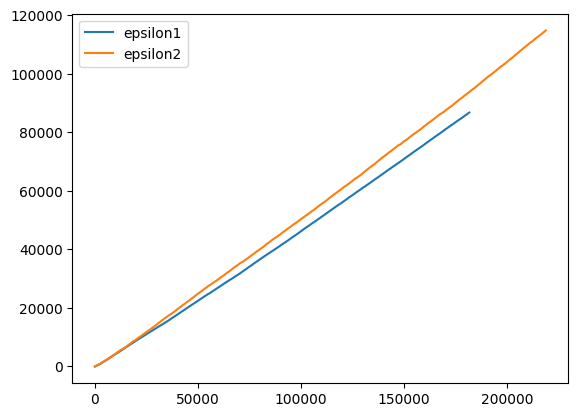

In [20]:
plt.plot(np.cumsum(rewards), label='epsilon1')
plt.plot(np.cumsum(rewards2), label='epsilon2')
plt.legend()
plt.plot()

### Varying $\varepsilon_t$

In [48]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history3 = pd.DataFrame(data=None, columns=df.columns)
history3 = history.astype({'movieId': 'int32', 'liked': 'float'})

In [49]:
c = 1e5

In [50]:
# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards3 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	if t == 0:
		epsilon3 = c
	else:
		epsilon3 = c/t
	if t % 10:
		print(epsilon3)
	recs = epsilon_greedy_policy(df=history3.loc[history3.t<=t,], arms=df.movieId.unique(), epsilon=epsilon3, slate_size=n, batch_size=batch_size)
	history3, action_score = score(history3, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards3.extend(action_score)

[]

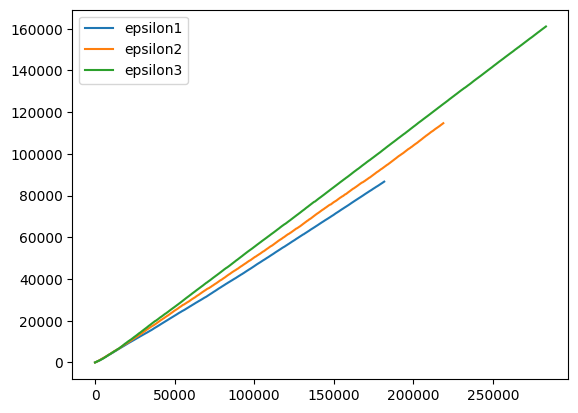

In [51]:
plt.plot(np.cumsum(rewards), label='epsilon1')
plt.plot(np.cumsum(rewards2), label='epsilon2')
plt.plot(np.cumsum(rewards3), label='epsilon3')
plt.legend()
plt.plot()

different end time since in the training loop we check if we can receive a feed back, not equal among all run

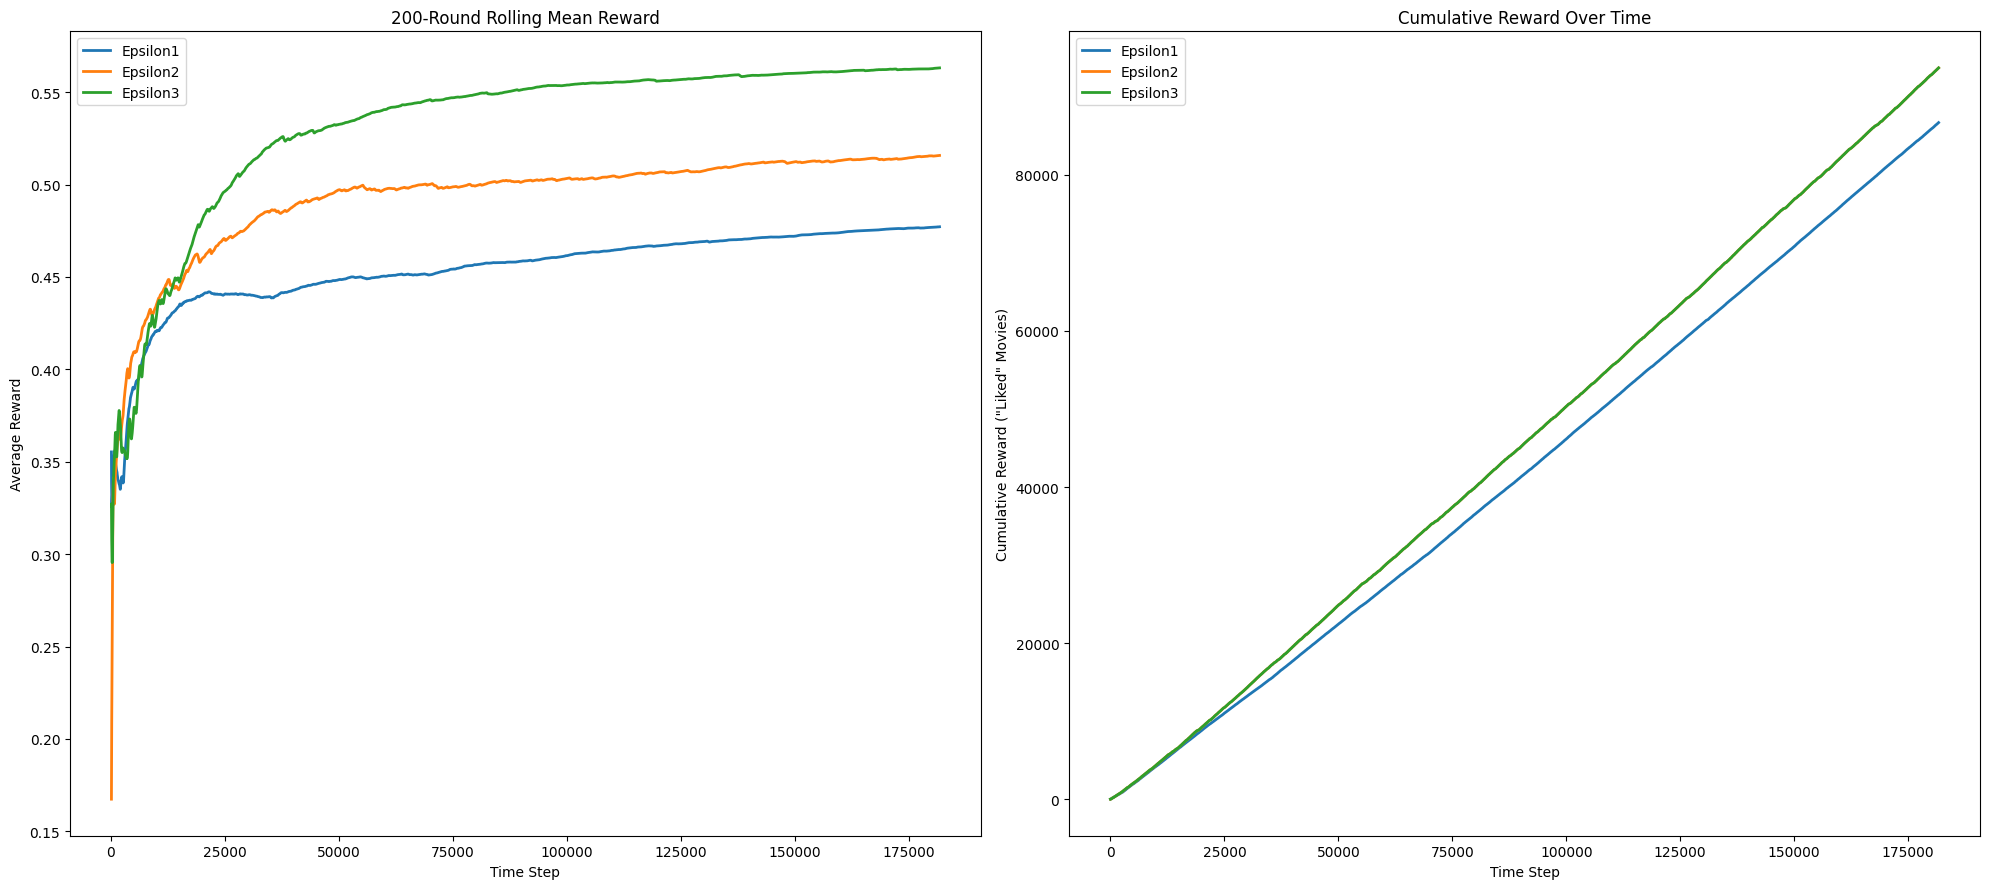

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

L = min(len(rewards), len(rewards2), len(rewards3))
lw=2

cumulative_epsilon1 = np.cumsum(rewards[:L]) 
cumulative_epsilon2 = np.cumsum(rewards2[:L])
cumulative_epsilon3 = np.cumsum(rewards3[:L])

axes[1].plot(pd.Series(cumulative_epsilon1), lw=lw, label='Epsilon1')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='Epsilon2')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='Epsilon3')


axes[1].set_title('Cumulative Reward Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Cumulative Reward ("Liked" Movies)')
axes[1].legend()


cumulative_epsilon1 = np.cumsum(rewards[:L]) / np.linspace(1, len(rewards[:L]), len(rewards[:L]))
cumulative_epsilon2 = np.cumsum(rewards2[:L]) / np.linspace(1, len(rewards2[:L]), len(rewards2[:L]))
cumulative_epsilon3 = np.cumsum(rewards3[:L]) / np.linspace(1, len(rewards3[:L]), len(rewards3[:L]))

axes[0].plot(pd.Series(cumulative_epsilon1).rolling(200).mean(), lw=lw, label='Epsilon1')
axes[0].plot(pd.Series(cumulative_epsilon2).rolling(200).mean(), lw=lw, label='Epsilon2')
axes[0].plot(pd.Series(cumulative_epsilon3).rolling(200).mean(), lw=lw, label='Epsilon3')
axes[0].set_title('200-Round Rolling Mean Reward')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Average Reward')
axes[0].legend()

fig.tight_layout()

# Test

In [27]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})

#def c in c/t for eps greedy 4
c=1e1

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)

	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history.loc[history.t<=t,], arms=df.movieId.unique(), c=c, t=t, slate_size=n, batch_size=batch_size, fixed=False)
	history, action_score = score(history, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards.extend(action_score)


In [28]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history2 = pd.DataFrame(data=None, columns=df.columns)
history2 = history.astype({'movieId': 'int32', 'liked': 'float'})

#def c in c/t for eps greedy 4
c2=1e3

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards2 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)

	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history2.loc[history2.t<=t,], arms=df.movieId.unique(), c=c2, t=t, slate_size=n, batch_size=batch_size, fixed=False)
	history2, action_score = score(history2, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards2.extend(action_score)


In [29]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history3 = pd.DataFrame(data=None, columns=df.columns)
history3 = history.astype({'movieId': 'int32', 'liked': 'float'})

#def c in c/t for eps greedy 4
c3=1e5

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards3 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)

	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history3.loc[history3.t<=t,], arms=df.movieId.unique(), c=c3, t=t, slate_size=n, batch_size=batch_size, fixed=False)
	history3, action_score = score(history3, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards3.extend(action_score)


In [30]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history4 = pd.DataFrame(data=None, columns=df.columns)
history4 = history.astype({'movieId': 'int32', 'liked': 'float'})

#def c in c/t for eps greedy 4
c4=1e8

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards4 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)

	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history4.loc[history4.t<=t,], arms=df.movieId.unique(), c=c4, t=t, slate_size=n, batch_size=batch_size, fixed=False)
	history4, action_score = score(history4, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards4.extend(action_score)


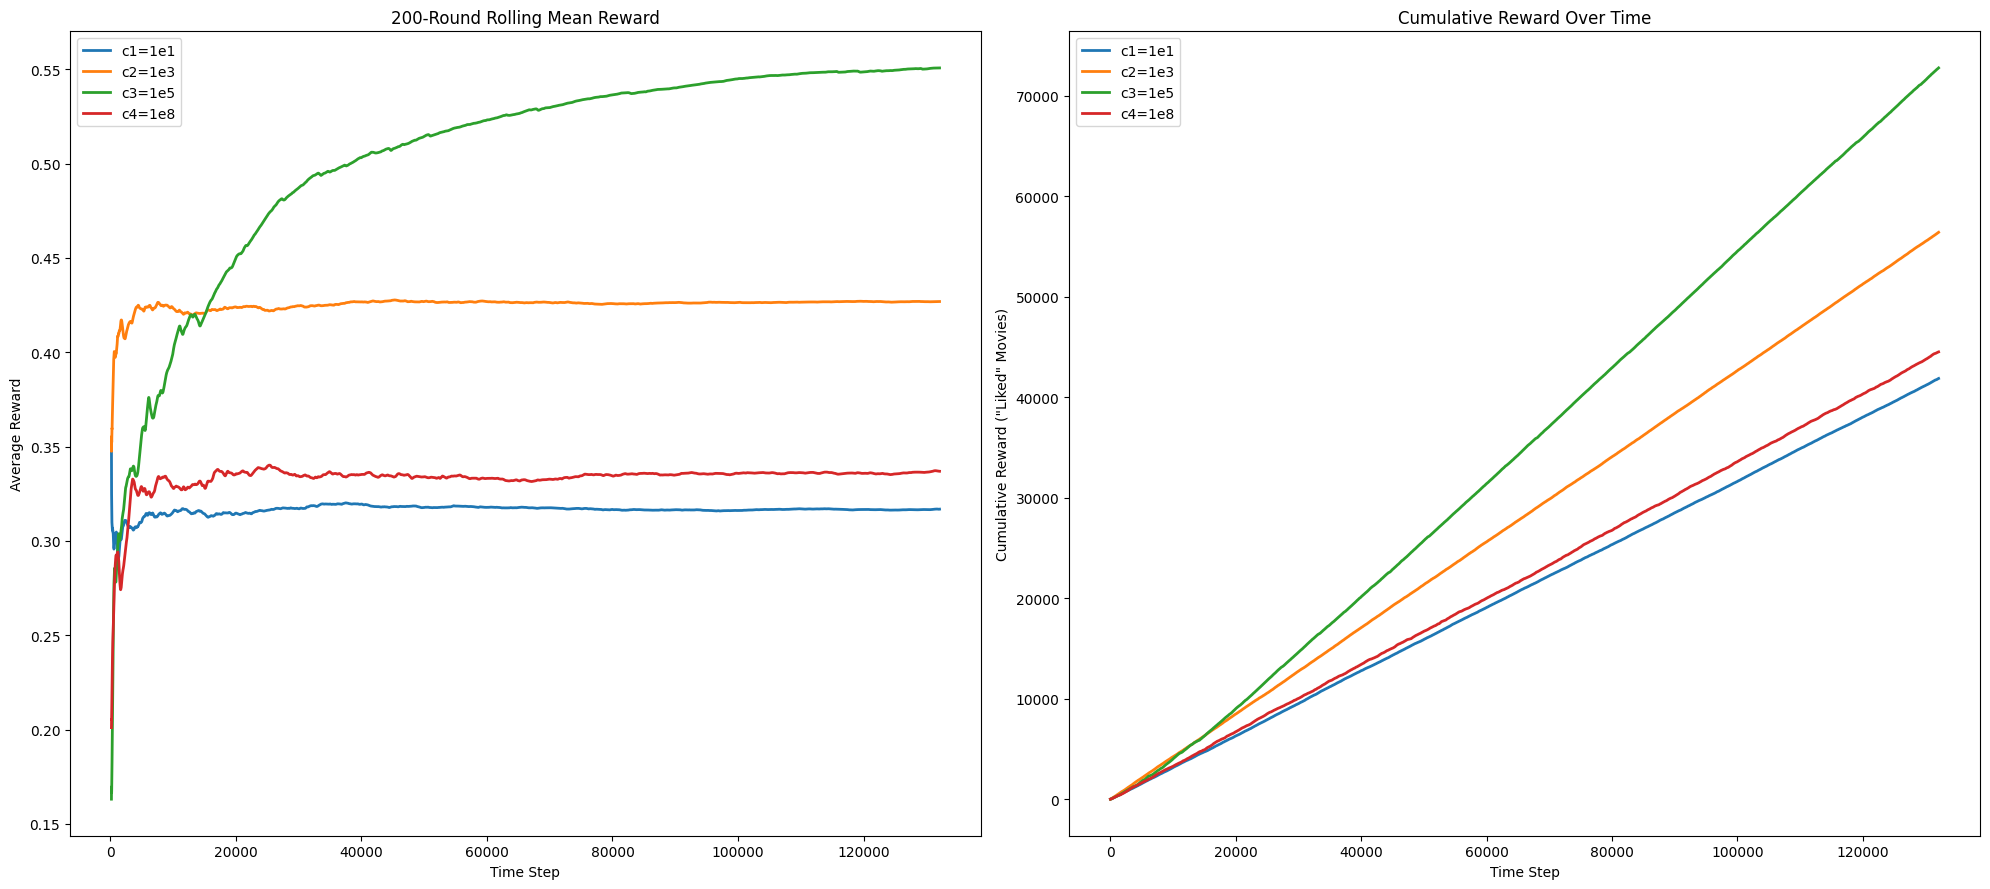

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

L = min(len(rewards), len(rewards2), len(rewards3), len(rewards4))
lw=2

cumulative_epsilon1 = np.cumsum(rewards[:L]) 
cumulative_epsilon2 = np.cumsum(rewards2[:L])
cumulative_epsilon3 = np.cumsum(rewards3[:L])
cumulative_epsilon4 = np.cumsum(rewards4[:L])

axes[1].plot(pd.Series(cumulative_epsilon1), lw=lw, label='c1=1e1')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='c2=1e3')
axes[1].plot(pd.Series(cumulative_epsilon3), lw=lw, label='c3=1e5')
axes[1].plot(pd.Series(cumulative_epsilon4), lw=lw, label='c4=1e8')



axes[1].set_title('Cumulative Reward Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Cumulative Reward ("Liked" Movies)')
axes[1].legend()


cumulative_epsilon1 = np.cumsum(rewards[:L]) / np.linspace(1, len(rewards[:L]), len(rewards[:L]))
cumulative_epsilon2 = np.cumsum(rewards2[:L]) / np.linspace(1, len(rewards2[:L]), len(rewards2[:L]))
cumulative_epsilon3 = np.cumsum(rewards3[:L]) / np.linspace(1, len(rewards3[:L]), len(rewards3[:L]))
cumulative_epsilon4 = np.cumsum(rewards4[:L]) / np.linspace(1, len(rewards4[:L]), len(rewards4[:L]))


axes[0].plot(pd.Series(cumulative_epsilon1).rolling(200).mean(), lw=lw, label='c1=1e1')
axes[0].plot(pd.Series(cumulative_epsilon2).rolling(200).mean(), lw=lw, label='c2=1e3')
axes[0].plot(pd.Series(cumulative_epsilon3).rolling(200).mean(), lw=lw, label='c3=1e5')
axes[0].plot(pd.Series(cumulative_epsilon4).rolling(200).mean(), lw=lw, label='c4=1e8')
axes[0].set_title('200-Round Rolling Mean Reward')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Average Reward')
axes[0].legend()

fig.tight_layout()

## Now use Regret Balancing with this base learner

In [34]:

def RunRegretBalancingEpsilonGreedy(df, history, learners, slate_size, batch_size, verbose=False):
    #history_init = history.copy()
    history_init_RB = history.copy()
    arms = df.movieId.unique()
    K = len(arms)
    R = np.zeros(len(learners))
    N = np.ones(len(learners))
    G = np.zeros(len(learners))
    t = 0
    rewards = []
    max_time = df.shape[0]
    

    # Iterate over batches
    for step in range(max_time // batch_size):
        t = step * batch_size
        u_bound = lambda t: np.sqrt(K * t)

        # Print progress if verbose is enabled
        if verbose and t % 100000 == 0:
            print(f"Processing step {t}...")

        set_to_maximize_index = [(R[i] / N[i]) + (u_bound(t) / N[i]) for i in range(len(learners))]
        j_t = np.argmax(set_to_maximize_index)
        b_t = set_to_maximize_index[j_t]
        # Empirical regret of base i at round t:

        G = N * b_t - R
        i_t = np.argmin(G)

        recs = epsilon_greedy_policy(df=history_init_RB.loc[history_init_RB.t<=t,], arms=df.movieId.unique(), c=learners[i_t], t=t, slate_size=slate_size, batch_size=batch_size, fixed=False)
        N[i_t] += 1
        # Score the recommendations and update history
        history_init_RB, action_score = score(history_init_RB, df, t, batch_size, recs)

        # Accumulate rewards from action scores
        if action_score is not None:
            Rs = action_score.liked.tolist()
            rewards.extend(Rs)
            R[i_t] += np.sum(Rs)
        
    return rewards, history_init_RB

In [33]:
learners = [c, c2, c3, c4]

In [36]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history_rb = pd.DataFrame(data=None, columns=df.columns)
history_rb = history.astype({'movieId': 'int32', 'liked': 'float'})

In [37]:
rewardsRB, historyRB = RunRegretBalancingEpsilonGreedy(df, history_rb, learners=learners, slate_size=n, batch_size=batch_size)

In [40]:
# Update rcParams
plt.rcParams.update({
    'axes.titlesize': 16,           # Title size for the axes
    'axes.labelsize': 16,           # Label size for the axes
    'xtick.labelsize': 14,          # Label size for x-axis ticks
    'ytick.labelsize': 14,          # Label size for y-axis ticks
    'legend.fontsize': 12,          # Font size for legend
    'text.usetex': True,            # Use LaTeX for text rendering
    'font.family': 'serif',         # Use serif font (LaTeX default)
})

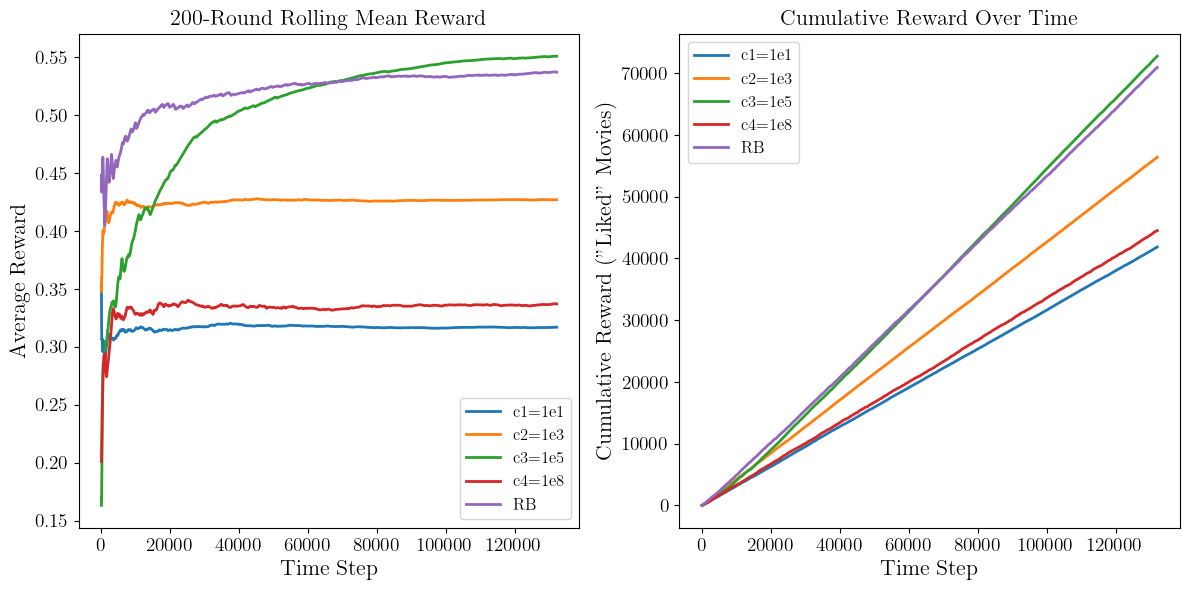

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

L = min(len(rewards), len(rewards2), len(rewards3), len(rewards4), len(rewardsRB))
lw=2

cumulative_epsilon1 = np.cumsum(rewards[:L]) 
cumulative_epsilon2 = np.cumsum(rewards2[:L])
cumulative_epsilon3 = np.cumsum(rewards3[:L])
cumulative_epsilon4 = np.cumsum(rewards4[:L])
cumulative_epsilonRB = np.cumsum(rewardsRB[:L])

axes[1].plot(pd.Series(cumulative_epsilon1), lw=lw, label='c1=1e1')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='c2=1e3')
axes[1].plot(pd.Series(cumulative_epsilon3), lw=lw, label='c3=1e5')
axes[1].plot(pd.Series(cumulative_epsilon4), lw=lw, label='c4=1e8')
axes[1].plot(pd.Series(cumulative_epsilonRB), lw=lw, label='RB')


axes[1].set_title('Cumulative Reward Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Cumulative Reward ("Liked" Movies)')
axes[1].legend()


cumulative_epsilon1 = np.cumsum(rewards[:L]) / np.linspace(1, len(rewards[:L]), len(rewards[:L]))
cumulative_epsilon2 = np.cumsum(rewards2[:L]) / np.linspace(1, len(rewards2[:L]), len(rewards2[:L]))
cumulative_epsilon3 = np.cumsum(rewards3[:L]) / np.linspace(1, len(rewards3[:L]), len(rewards3[:L]))
cumulative_epsilon4 = np.cumsum(rewards4[:L]) / np.linspace(1, len(rewards4[:L]), len(rewards4[:L]))
cumulative_epsilonRB = np.cumsum(rewardsRB[:L]) / np.linspace(1, len(rewardsRB[:L]), len(rewardsRB[:L]))


axes[0].plot(pd.Series(cumulative_epsilon1).rolling(200).mean(), lw=lw, label='c1=1e1')
axes[0].plot(pd.Series(cumulative_epsilon2).rolling(200).mean(), lw=lw, label='c2=1e3')
axes[0].plot(pd.Series(cumulative_epsilon3).rolling(200).mean(), lw=lw, label='c3=1e5')
axes[0].plot(pd.Series(cumulative_epsilon4).rolling(200).mean(), lw=lw, label='c4=1e8')
axes[0].plot(pd.Series(cumulative_epsilonRB).rolling(200).mean(), lw=lw, label='RB')
axes[0].set_title('200-Round Rolling Mean Reward')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Average Reward')
axes[0].legend()

fig.tight_layout()